<a href="https://colab.research.google.com/github/paddy-03/Sentiment-Analysis-Amazon-Fine-Food-Reviews/blob/master/Text_clustering_Amazon_Food_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import warnings
warnings.filterwarnings("ignore")

import scipy
import math
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.snowball import SnowballStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
os.chdir('./drive/My Drive/amazon_food_reviews')

In [0]:
sql = sqlite3.connect('database.sqlite')
raw_data = pd.read_sql_query(""" SELECT * FROM Reviews """, sql)


In [0]:
raw_data.shape

(568454, 10)

In [0]:
#filtering all data and rejecting the entries with score 3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews LIMIT 10000""", sql)

#function to label the score, if 4 or 5 score is positive else negetive

filtered_data.head(3)


Id  ...                                               Text
0   1  ...  I have bought several of the Vitality canned d...
1   2  ...  Product arrived labeled as Jumbo Salted Peanut...
2   3  ...  This is a confection that has been around a fe...

[3 rows x 10 columns]

In [0]:
filtered_data.shape

(10000, 10)

## Exploratory Data Analysis

### 1) Distribution of the different scores

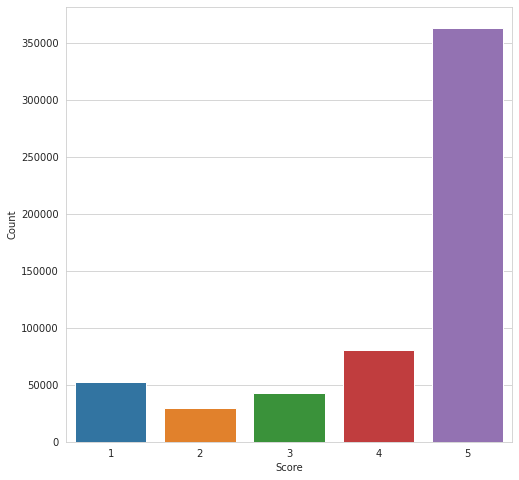

In [0]:
score_count = pd.read_sql_query(""" SELECT Score,count(*) FROM Reviews group by Score""", sql)

plt.figure(figsize = (8, 8)) 
sns.set_style("whitegrid");
sns.barplot(x=score_count["Score"],y=score_count["count(*)"])
plt.ylabel("Count")
plt.show();

**Observation:**

Most of the reviewers rated positively, the number of reviews getting a score of 5 is very high.

### 2) Scores and Helpfulness

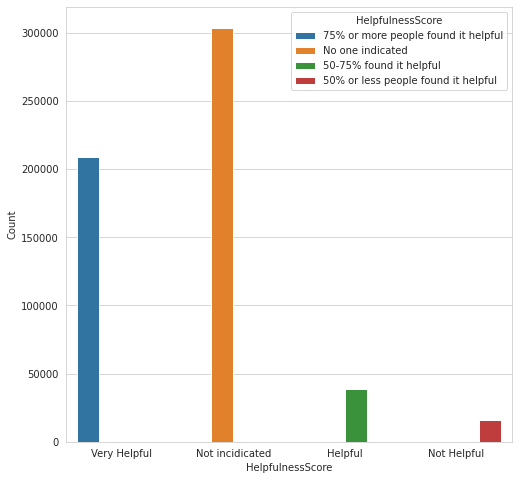

In [0]:
raw_data["HelpfulnessScore"] = raw_data["HelpfulnessNumerator"]/raw_data["HelpfulnessDenominator"]

def intervals(s):

  if s==0 or math.isnan(s):
    return "Not incidicated"
  elif s >= 0.75:
    return "Very Helpful"
  elif s>=0.5 and s<0.75:
    return "Helpful"
  else:
    return "Not Helpful"

raw_data["HelpfulnessScore"] = raw_data["HelpfulnessScore"].map(intervals)
Intervals = np.unique(raw_data["HelpfulnessScore"])
helpful_count = raw_data.groupby(["HelpfulnessScore"]).agg(['count'])["Id"]
helpful_count["count"] = helpful_count["count"]/len(raw_data) *100
plt.figure(figsize = (8, 8)) 
g = sns.countplot(x=raw_data["HelpfulnessScore"], hue=raw_data["HelpfulnessScore"])
plt.ylabel("Count")
plt.legend(title='HelpfulnessScore', labels=['75% or more people found it helpful', 'No one indicated', '50-75% found it helpful', '50% or less people found it helpful'])
plt.show(g)

**Observation:**

Most of the reviews(more than 50%) had no indication. While mostly the reviews which had indication were found to be very helpful that is more than 75% people who voted found it helpful. 

In [0]:
Intervals

array(['Helpful', 'Not Helpful', 'Not incidicated', 'Very Helpful'],
      dtype=object)

In [0]:
def ishelpful(s):

  if s=='Helpful' or s=='Very Helpful':
    return "Helpful"
  elif s == 'Not Helpful':
    return "Not Helpful"


isHelpful = pd.DataFrame(raw_data["HelpfulnessScore"].map(ishelpful))
isHelpful["Score"] = raw_data["Score"]

In [0]:
isHelpful.dropna(inplace = True)

In [0]:
isHelpful.head()

HelpfulnessScore  Score
0           Helpful      5
2           Helpful      4
3           Helpful      2
8           Helpful      5
10          Helpful      5

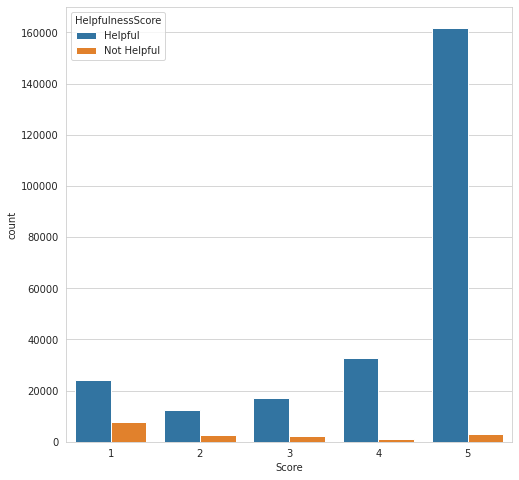

In [0]:
plt.figure(figsize = (8, 8)) 
g = sns.countplot(x=isHelpful["Score"], hue=isHelpful["HelpfulnessScore"] )#,estimator=lambda x: len(x) / len(isHelpful) * 100)
plt.show(g)

## **Data Cleaning**

In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", sql)

In [0]:
display.head()

UserId  ... COUNT(*)
0  #oc-R115TNMSPFT9I7  ...        2
1  #oc-R11D9D7SHXIJB9  ...        3
2  #oc-R11DNU2NBKQ23Z  ...        2
3  #oc-R11O5J5ZVQE25C  ...        3
4  #oc-R12KPBODL2B5ZD  ...        2

[5 rows x 7 columns]

In [0]:
display.shape

(80668, 7)

In [0]:
pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text
FROM Reviews
where UserId = '#oc-R11D9D7SHXIJB9'

""", sql)

UserId  ...                                               Text
0  #oc-R11D9D7SHXIJB9  ...  My wife has recurring extreme muscle spasms, u...
1  #oc-R11D9D7SHXIJB9  ...  My wife has recurring extreme muscle spasms, u...
2  #oc-R11D9D7SHXIJB9  ...  My wife has recurring extreme muscle spasms, u...

[3 rows x 6 columns]

**Observation**

Duplicate entries present, although the product ids differ but it's not possible to have multiple entries by a same user at a given timestamp. The different products are basically variations of a single product only, hence as the text too is same, the duplicate entries must be removed.

In [0]:
filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False).shape

(9515, 10)

In [0]:
filtered_data = filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [0]:
filtered_data['Score'].value_counts()

5    5930
4    1355
1     884
3     797
2     549
Name: Score, dtype: int64

## **Text Preprocessing**

**Tasks to do:**

1. Removing words with HTML tags
2. Removing URLs
3. Converting all words to lowercase
4. Removing all special characters and punctuation marks
5. Removing alpha-numeric words
6. Removing Stopwords
7. Lemmatization

  

In [0]:
def removeHTMLtags(s):
  comp = re.compile('<.*>')
  return re.sub(comp,'',s)

In [0]:
def removeURLs(s):
  return re.sub(r'http\S+', '', s)

In [0]:
def toLower(s):
   return s.lower()

In [0]:
def removeSpl(s):
  return s.translate(str.maketrans('', '', string.punctuation))

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [0]:
def removealphanum(s):
   return re.sub("\S*\d\S*", "", s).strip()

In [0]:
nltk.download('stopwords')
stop = list(set(nltk.corpus.stopwords.words('english')))
ctr = 0
for i in stop:
    print ("'" +i+"'"+', ',end='')
    ctr=ctr+1
    if(ctr==15):
      print()
      ctr=0

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
'himself', 'itself', 'these', 'yourselves', 'myself', 'mustn't', 'will', 'through', 'couldn't', 'against', 'they', 'y', 'you're', 'being', 'own', 
'hadn', 'no', 'under', 'above', 'here', 'that', 'she', 'only', 'below', 'nor', 'can', 'its', 'for', 'were', 'very', 
't', 'with', 'couldn', 'needn't', 'mightn', 'is', 'their', 'ourselves', 'of', 'this', 'about', 've', 'theirs', 'shan', 'yourself', 
'hasn', 'wouldn', 'just', 'do', 'a', 'ours', 'if', 'didn', 'that'll', 'having', 'was', 'when', 'shouldn't', 'because', 'where', 
'which', 'her', 'aren't', 'o', 'before', 'ma', 'than', 'his', 'why', 'further', 're', 'mustn', 'me', 'them', 'themselves', 
'into', 'should', 'hasn't', 'did', 'whom', 'you'd', 'he', 'needn', 'weren't', 'each', 'in', 'while', 'there', 'ain', 'have', 
'doing', 'isn't', 'hers', 'from', 'you'll', 'shan't', 'be', 'down', 'shouldn', 'isn', 'most', 'too', 'wasn

In [0]:
stop.append('taste')
stop.append('flavor')
stop.append('good')
stop.append('great')
stop.append('like')
stop.append('love')
stop.append('make')

In [0]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [0]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [0]:
lemmatizer = WordNetLemmatizer()

In [0]:
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(filtered_data['Text'].values):
    sentance = removeHTMLtags(sentance)
    sentance = removeURLs(sentance)
    sentance = toLower(sentance)
    sentance = removeSpl(sentance)
    sentance = removealphanum(sentance)
    sentance = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in sentance.split()] # Lemmatizatiom
    sentance = ' '.join(e.lower() for e in sentance if e.lower() not in stop) #removing stop words
    preprocessed_reviews.append(sentance.strip()) 

100%|██████████| 9515/9515 [01:16<00:00, 124.57it/s]


## **Featurization**

### Bag of Words: Count Vectorizer

In [0]:
#BoW
count_vect = CountVectorizer(max_df=1000, min_df=20) #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[90:100])
cv_feature_names = count_vect.get_feature_names()
np.save('cv_feature_names.npy',cv_feature_names)
print('='*50)

cv = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(cv))
print("the shape of out text BOW vectorizer ",cv.get_shape())
print("the number of unique words ", cv.get_shape()[1])

some feature names  ['awesome', 'awful', 'awhile', 'baby', 'back', 'bacon', 'bad', 'bag', 'bake', 'baking']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (9515, 1607)
the number of unique words  1607


In [0]:
from collections import Counter

In [0]:
freqs = zip(count_vect.get_feature_names(), cv.sum(axis=0).tolist()[0])   

In [0]:
bow = sorted(freqs, key=lambda x: -x[1])
bow[:20]

[('food', 1699),
 ('tea', 1478),
 ('chip', 1155),
 ('little', 1149),
 ('give', 1087),
 ('also', 1082),
 ('cup', 1081),
 ('amazon', 1049),
 ('bag', 1042),
 ('drink', 1009),
 ('ive', 991),
 ('dog', 980),
 ('im', 977),
 ('say', 967),
 ('even', 952),
 ('store', 950),
 ('mix', 940),
 ('add', 903),
 ('chocolate', 888),
 ('brand', 882)]

### TF-IDF Vectorizer

In [0]:
#Tf-Idf
tfidf_vect = TfidfVectorizer(max_df=1000, min_df=20) #in scikit-learn
tfidf_vect.fit(preprocessed_reviews)
print("some feature names ", tfidf_vect.get_feature_names()[90:100])
print('='*50)

tfidf = tfidf_vect.transform(preprocessed_reviews)
tfidf_feature_names = tfidf_vect.get_feature_names()
np.save('tfidf_feature_names.npy',tfidf_feature_names)
print("the type of tf-idf vectorizer ",type(tfidf))
print("the shape of out text tf-idf vectorizer ",tfidf.get_shape())
print("the number of unique words ", tfidf.get_shape()[1])

some feature names  ['awesome', 'awful', 'awhile', 'baby', 'back', 'bacon', 'bad', 'bag', 'bake', 'baking']
the type of tf-idf vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text tf-idf vectorizer  (9515, 1607)
the number of unique words  1607


In [0]:
tfidf_freqs = zip(tfidf_vect.get_feature_names(), tfidf.sum(axis=0).tolist()[0])   

In [0]:
tfidf_bow = sorted(tfidf_freqs, key=lambda x: -x[1])
tfidf_bow[:20]

[('tea', 204.68816467408448),
 ('food', 186.68225410514756),
 ('chip', 176.28886470020615),
 ('cup', 147.3856791947738),
 ('little', 146.35394309136328),
 ('dog', 143.72620810765355),
 ('chocolate', 140.99778457893754),
 ('amazon', 140.59933782015904),
 ('bag', 136.17662905255068),
 ('give', 133.2213024094298),
 ('ive', 132.6108497626425),
 ('drink', 132.07271905035674),
 ('store', 131.33586914925357),
 ('also', 126.85754817162832),
 ('mix', 125.68438063243926),
 ('im', 124.46546876658728),
 ('recommend', 122.6995472376156),
 ('say', 121.64459309881659),
 ('brand', 121.08603249381603),
 ('hot', 121.08429936501301)]

##K-Means

### Using BoW



In [0]:
from sklearn.cluster import KMeans

In [0]:
inertias = []
k_values = [2,5,10,25,50,100]

In [0]:

for k in tqdm(k_values):

  k_means= KMeans(n_clusters=k, init='k-means++')
  k_means.fit(scipy.sparse.csr_matrix.toarray(cv))
  inertias.append(k_means.inertia_)


100%|██████████| 6/6 [04:07<00:00, 41.21s/it]


In [0]:
inertias

array([270494.13007161, 260910.14734946, 253346.03483797, 242992.81769051,
       234375.73753391, 223938.64116866])

In [0]:
inertias = np.array(inertias)
np.save('cv_inertias.npy',inertias)

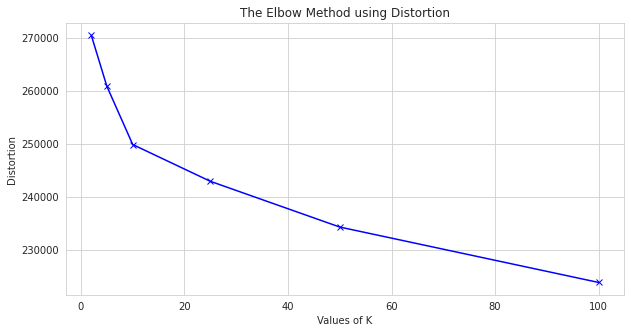

In [0]:

plt.figure(figsize=(10,5))
plt.plot(k_values, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()


K=10 seems optimal

In [0]:
k_means= KMeans(n_clusters=10, init='k-means++',n_jobs=-1)
k_means.fit(scipy.sparse.csr_matrix.toarray(cv))


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
np.unique(k_means.labels_,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([ 353,  292,   59,  118,  219,  661,   25,  321, 7080,  387]))

In [0]:
def word_clouds_kmeans(kmeans_object, optimal_k, X):
    '''This method is used to draw word clouds for the words available in all the reviews in different clusters.'''
    
    #Labels of each data point
    labels=kmeans_object.labels_
    clusters_dict = {i: np.where(labels == i)[0] for i in range(optimal_k)}
    # Transform this dictionary into list (if you need a list as result)
    clusters_list = []
    print("The number of datapoints in each cluster are as follows : ")
    for key, value in clusters_dict.items():
        temp = [key,value]
        clusters_list.append(temp)
        print("Cluster = {}, Number of reviews = {}".format(key,len(value)))

    from wordcloud import WordCloud    
    for cluster_number in range(optimal_k):
        cluster = [clusters_dict[cluster_number][i] for i in range(clusters_dict[cluster_number].size)]

        reviews_cluster = []
        for i in cluster: 
            reviews_cluster.append(X[i])

        review_corpus = ""   
        for review in reviews_cluster:
            review_corpus = review_corpus + " " + review

        # lower max_font_size
        wordcloud = WordCloud(width=800, height=450, margin=2, prefer_horizontal=0.9, scale=1, max_words=75, 
                              min_font_size=4, random_state=42, background_color='black', 
                              contour_color='black', repeat=False).generate(str(review_corpus))
        plt.figure(figsize=(16,9))
        plt.title("Word Cloud for Cluster {}".format(cluster_number))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

The number of datapoints in each cluster are as follows : 
Cluster = 0, Number of reviews = 353
Cluster = 1, Number of reviews = 292
Cluster = 2, Number of reviews = 59
Cluster = 3, Number of reviews = 118
Cluster = 4, Number of reviews = 219
Cluster = 5, Number of reviews = 661
Cluster = 6, Number of reviews = 25
Cluster = 7, Number of reviews = 321
Cluster = 8, Number of reviews = 7080
Cluster = 9, Number of reviews = 387


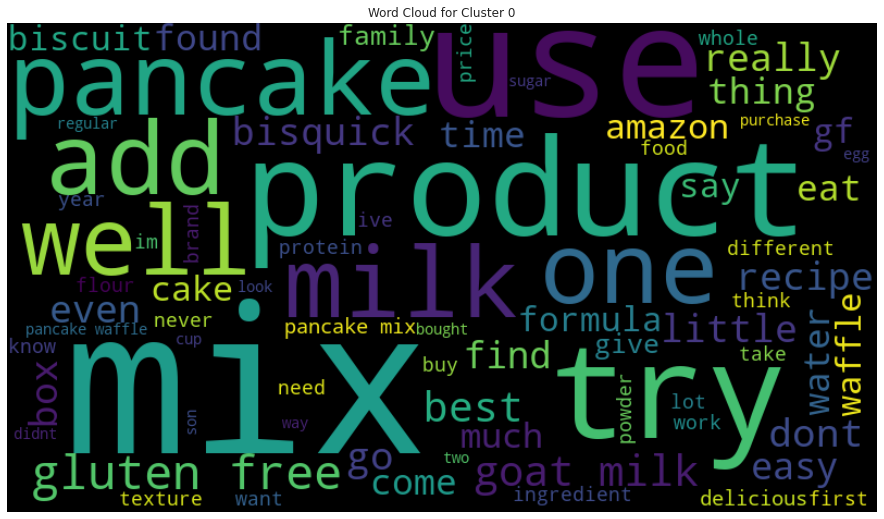

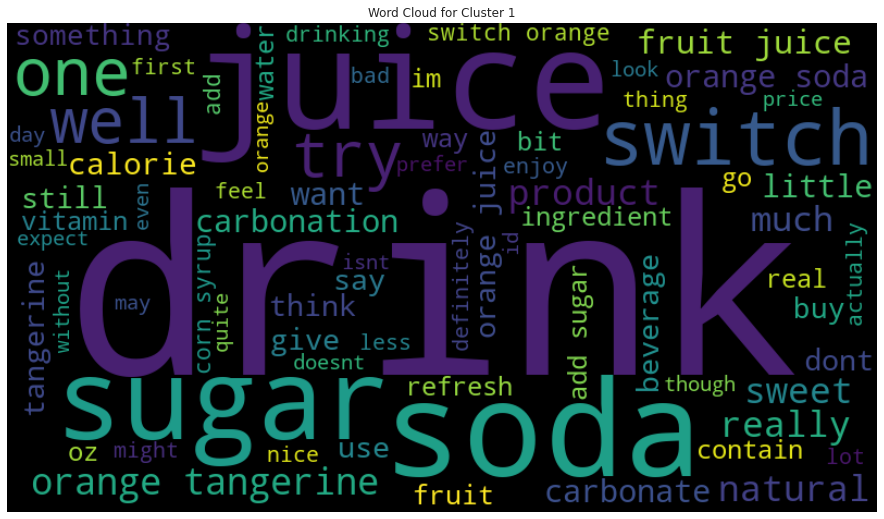

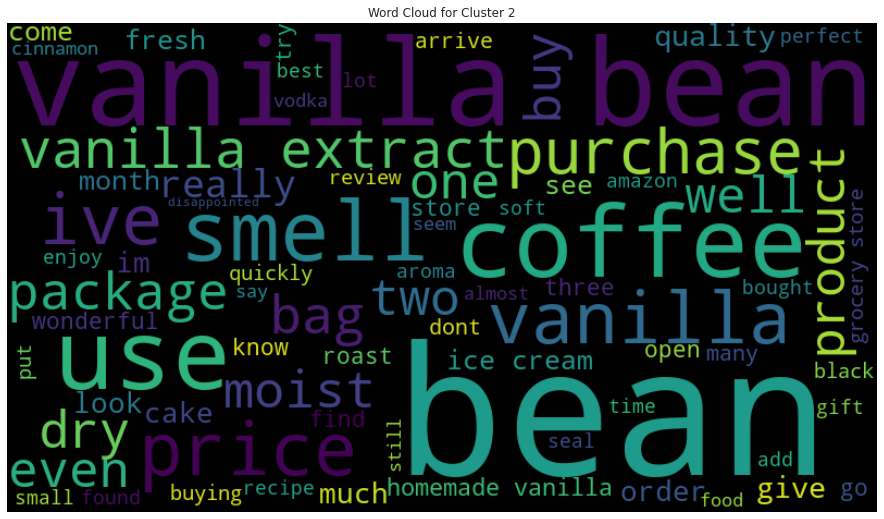

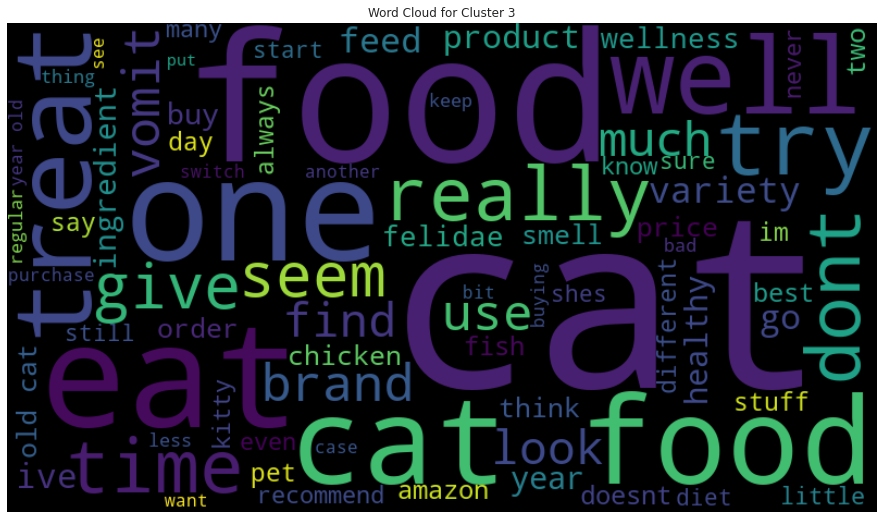

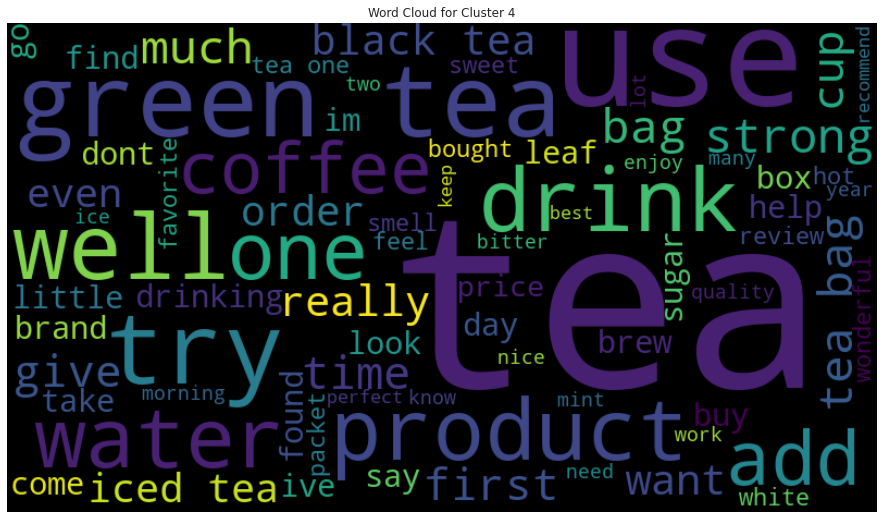

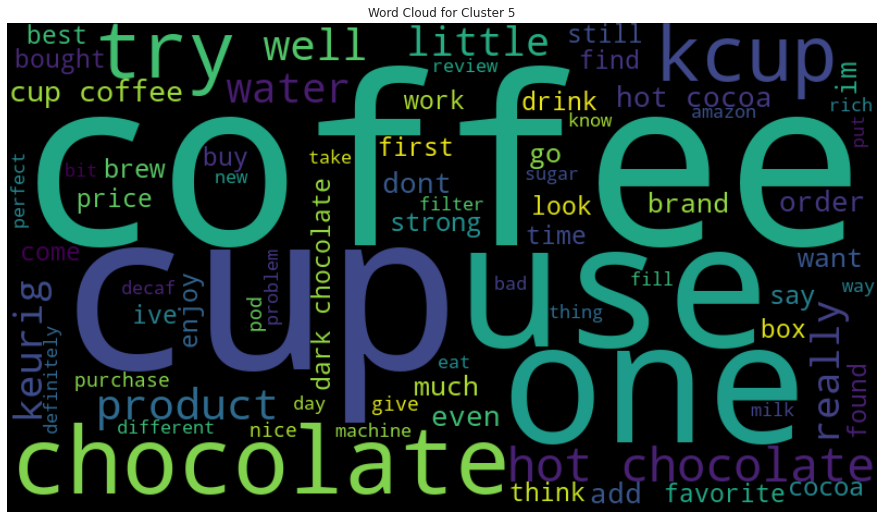

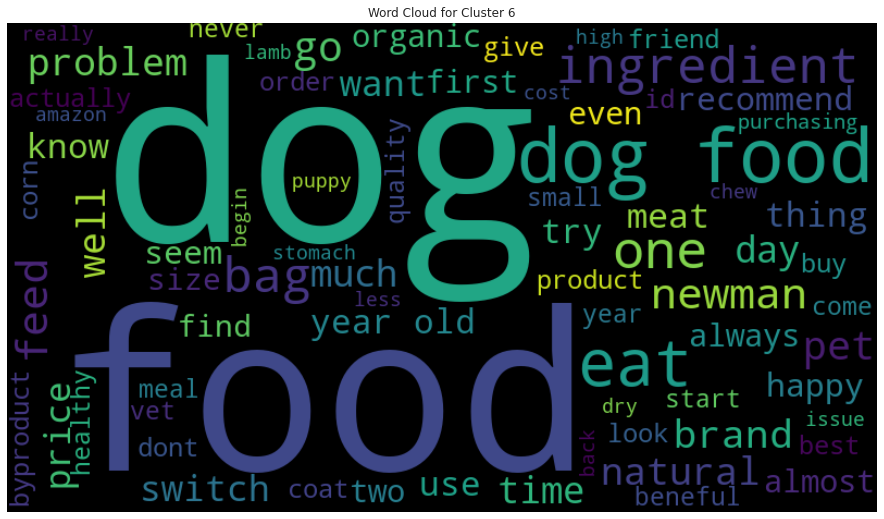

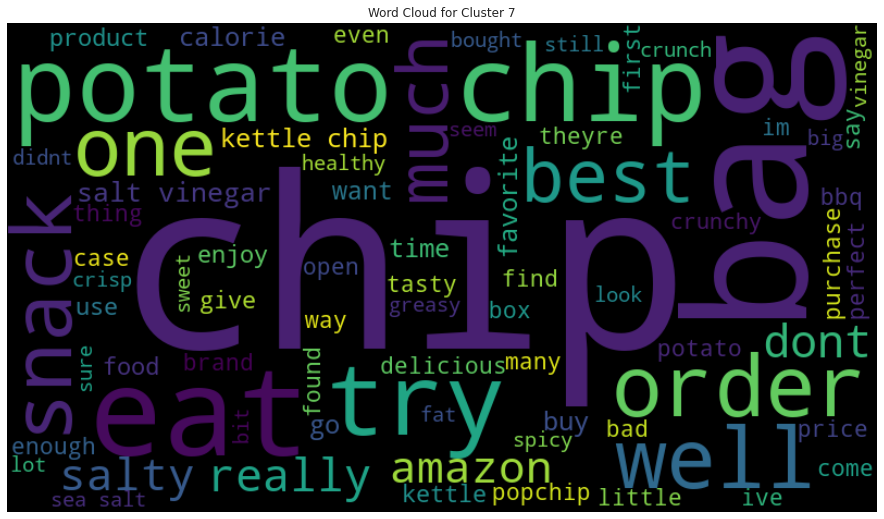

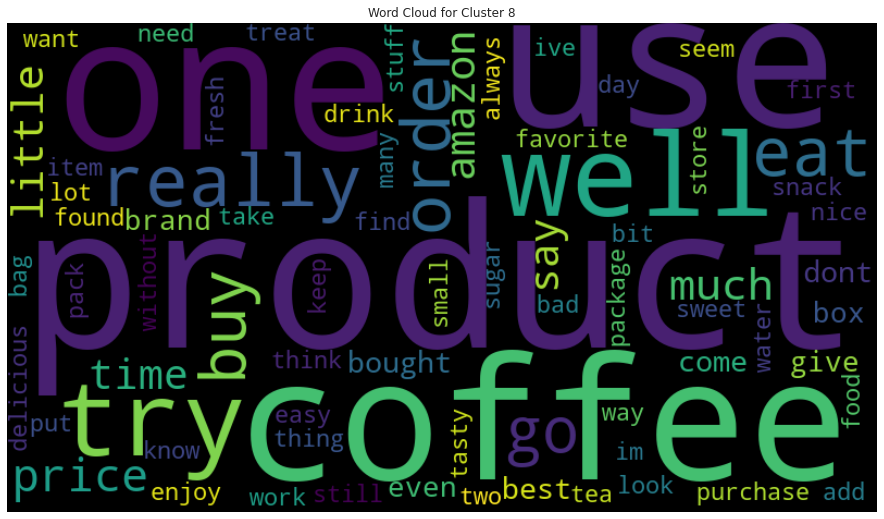

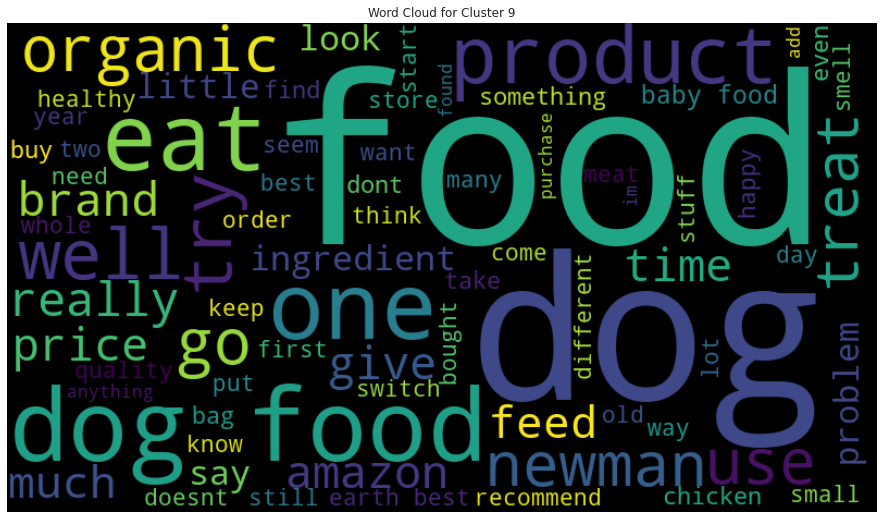

In [0]:
word_clouds_kmeans(k_means, 10 , preprocessed_reviews)

### Using Tf-Idf



In [0]:
from sklearn.cluster import KMeans

In [0]:
inertias_2 = []

In [0]:

for k in tqdm(k_values):

  k_means= KMeans(n_clusters=k, init='k-means++')
  k_means.fit(scipy.sparse.csr_matrix.toarray(tfidf))
  inertias_2.append(k_means.inertia_)


100%|██████████| 6/6 [05:41<00:00, 56.97s/it]


In [0]:
inertias_2

[9242.386986951378,
 9073.363348030467,
 8908.48780907292,
 8630.872915152042,
 8347.402875825826,
 8014.028235043888]

In [0]:
inertias_2 = np.array(inertias_2)
np.save('cv_inertias_2.npy',inertias_2)

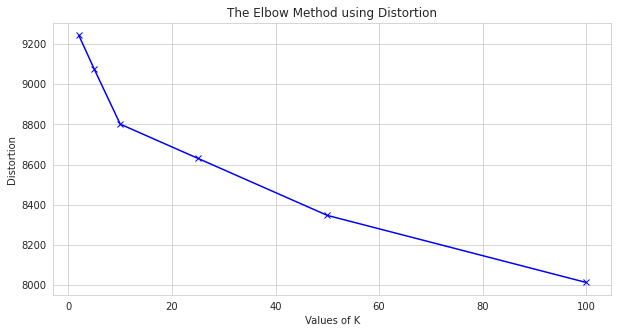

In [0]:
plt.figure(figsize=(10,5))
plt.plot(k_values, inertias_2, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 


 K=10 seems optimal

In [0]:
k_means= KMeans(n_clusters=10, init='k-means++')
k_means.fit(scipy.sparse.csr_matrix.toarray(tfidf))


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
np.unique(k_means.labels_,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([ 831, 4477,  457,  227,  471,  414,  345, 1396,  495,  402]))

The number of datapoints in each cluster are as follows : 
Cluster = 0, Number of reviews = 831
Cluster = 1, Number of reviews = 4477
Cluster = 2, Number of reviews = 457
Cluster = 3, Number of reviews = 227
Cluster = 4, Number of reviews = 471
Cluster = 5, Number of reviews = 414
Cluster = 6, Number of reviews = 345
Cluster = 7, Number of reviews = 1396
Cluster = 8, Number of reviews = 495
Cluster = 9, Number of reviews = 402


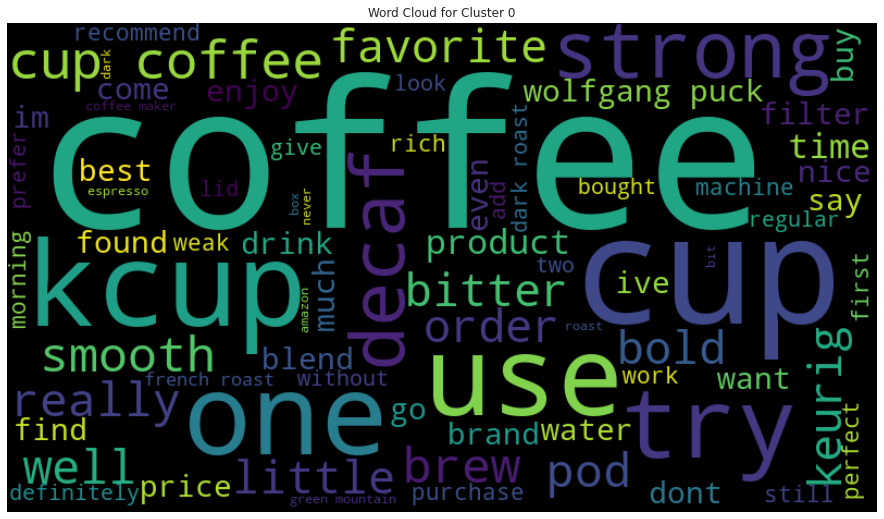

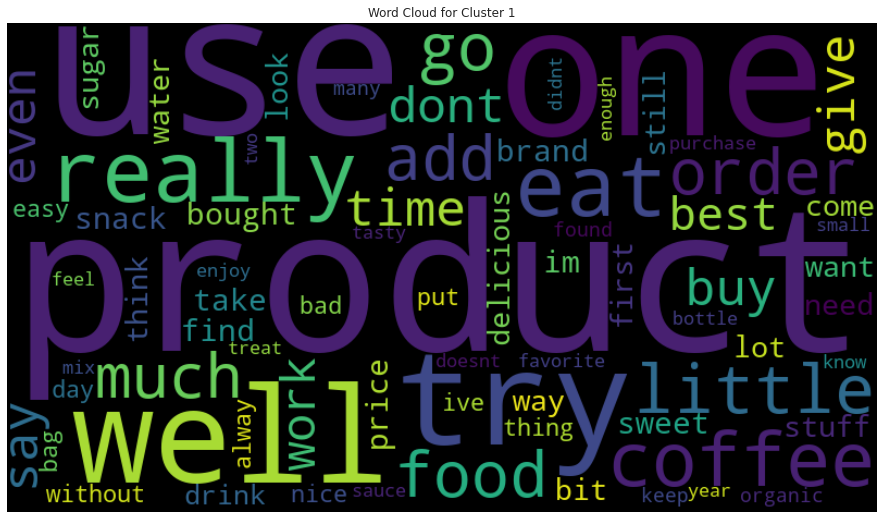

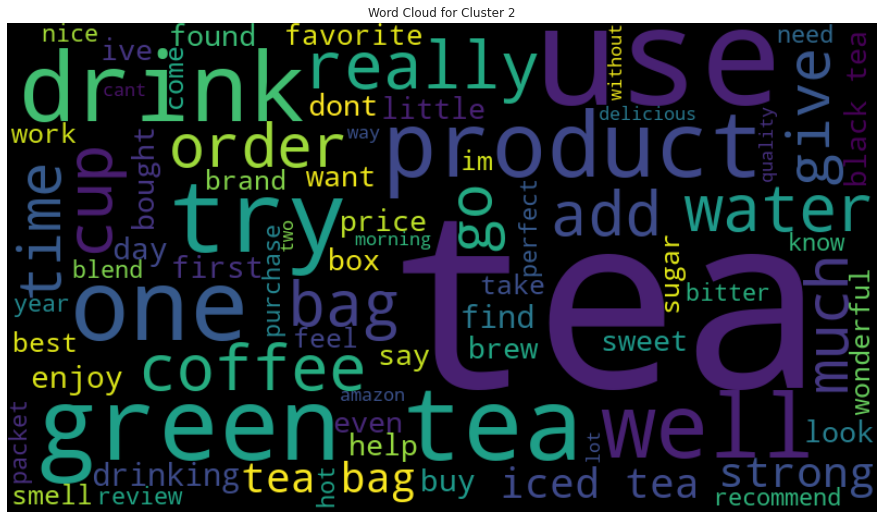

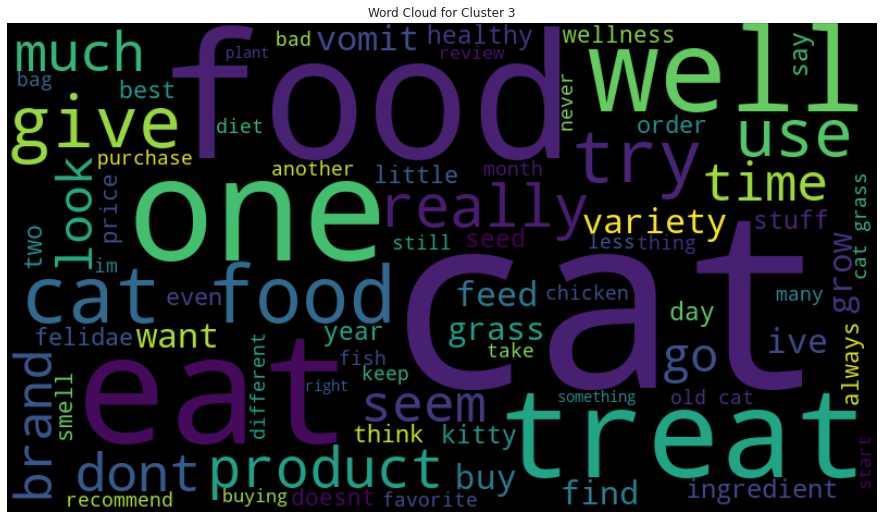

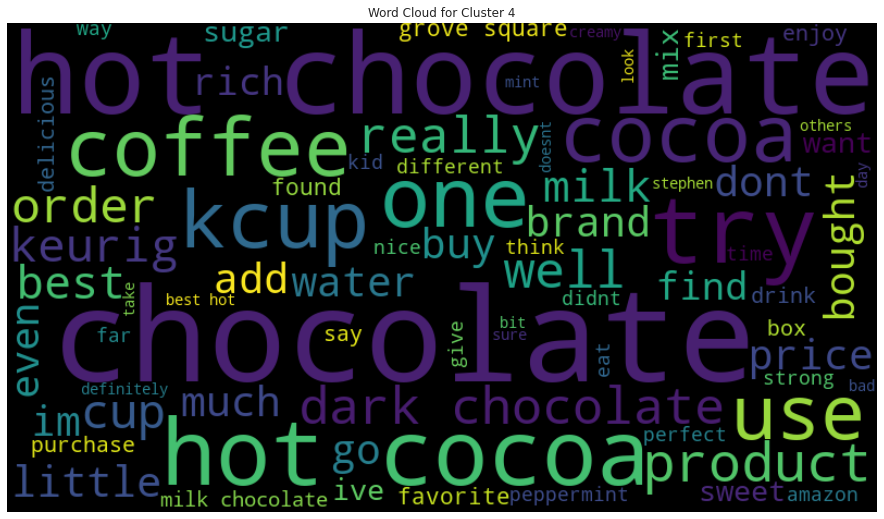

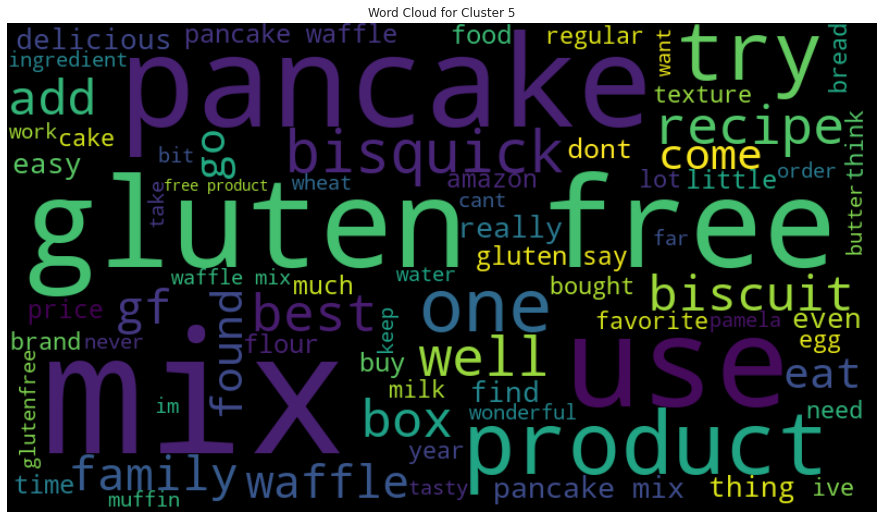

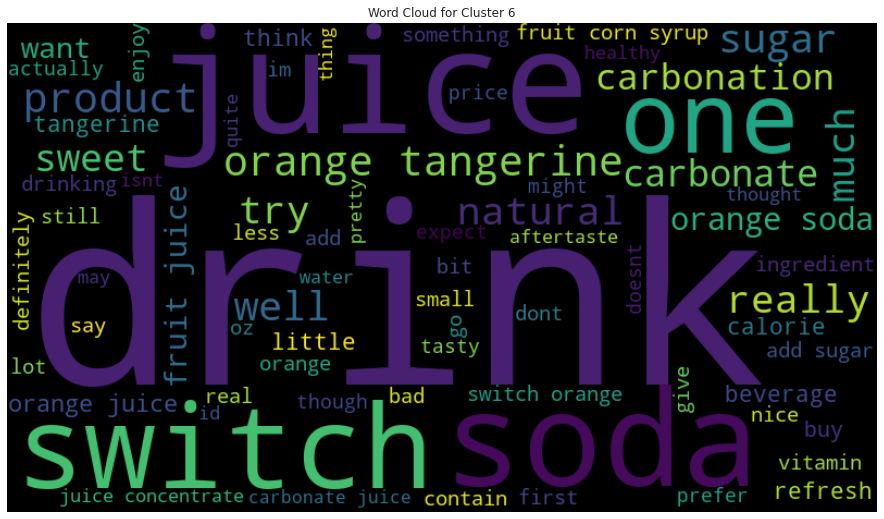

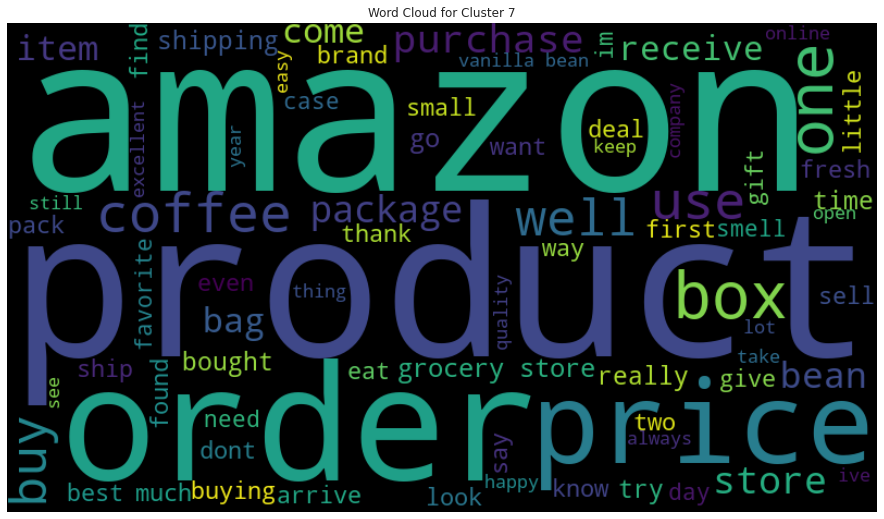

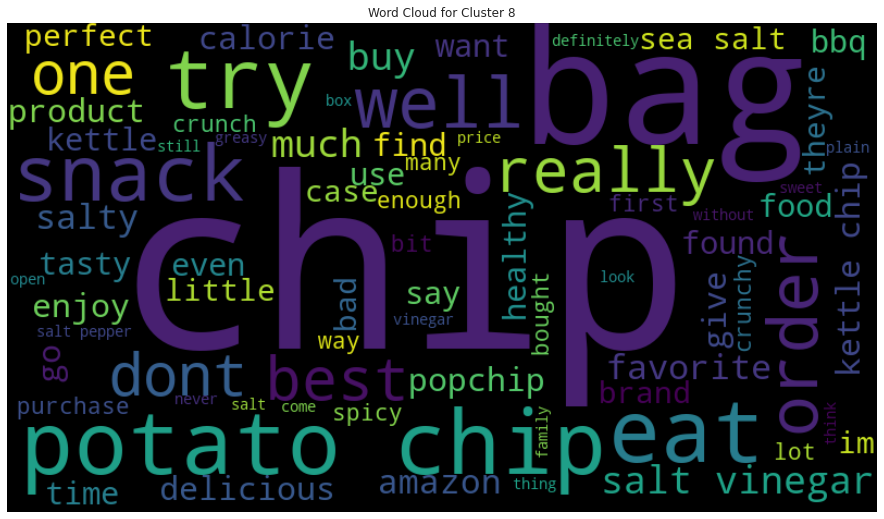

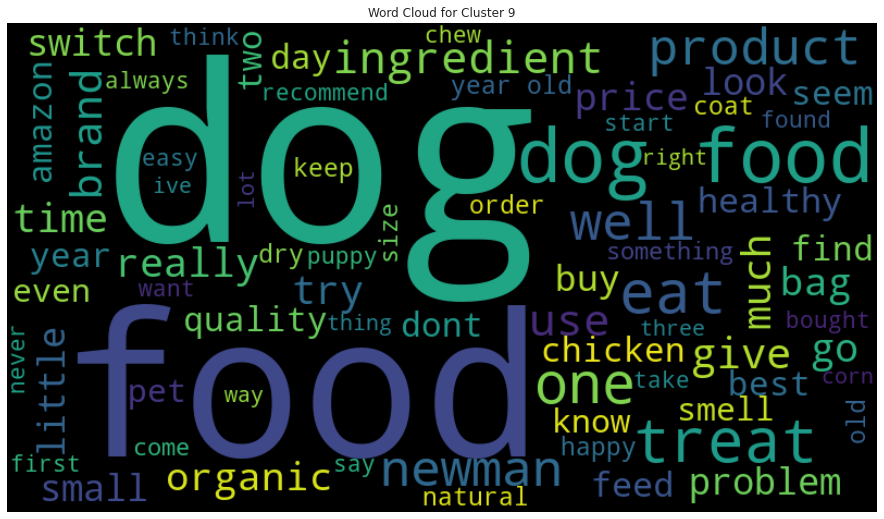

In [0]:
word_clouds_kmeans(k_means, 10 , preprocessed_reviews)